In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config IPCompleter.greedy=True

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')



In [9]:
train = pd.read_csv("E:/titanic/train.csv")
test = pd.read_csv("E:/titanic/test.csv")
IDtest = test["PassengerId"]

In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

C:\py\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
train_len = len(train)
print(train_len)

881


In [10]:
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\py\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [11]:
#printing the length of the whole dataset
print(len(dataset))

1309


In [12]:
#fill empty calues with nan
dataset = dataset.fillna(np.nan)

In [14]:
#get all the null value columns
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [15]:
#to get all null vlaues greatrer than 1
dataset.isnull().sum()[dataset.isnull().sum()>1]

Age          263
Cabin       1014
Embarked       2
Survived     418
dtype: int64

In [16]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
#GET THE DATA TYPES
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [18]:
train.select_dtypes(exclude = 'O')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500
5,6,0,3,NaN,0,0,8.4583
6,7,0,1,54.0,0,0,51.8625
7,8,0,3,2.0,3,1,21.0750
8,9,1,3,27.0,0,2,11.1333
9,10,1,2,14.0,1,0,30.0708


In [19]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [21]:
correlated = train[["Survived","SibSp","Parch","Age","Fare"]].corr()

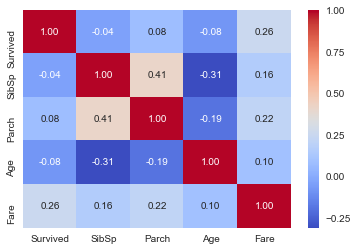

In [22]:
sns.heatmap(correlated, annot= True,fmt = "0.2f" ,cmap = 'coolwarm')

In [23]:
correlated[correlated>0.1]

,Survived,SibSp,Parch,Age,Fare
Survived,1.000000,NaN,NaN,NaN,0.257307
SibSp,NaN,1.000000,0.414838,NaN,0.159651
Parch,NaN,0.414838,1.000000,NaN,0.216225
Age,NaN,NaN,NaN,1.0,NaN
Fare,0.257307,0.159651,0.216225,NaN,1.000000


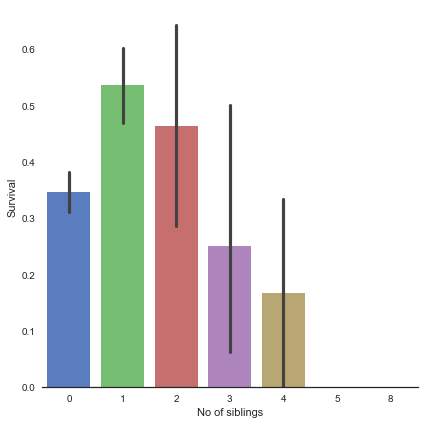

In [24]:
g =sns.factorplot(x= 'SibSp',y='Survived',data =train, kind = 'bar',size=6, palette='muted')
g.despine(left= True)
g.set_ylabels('Survival')
g.set_xlabels('No of siblings')

C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


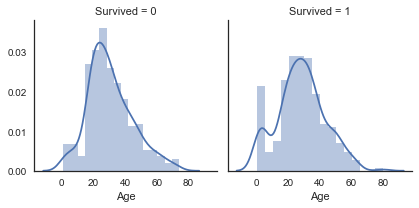

In [25]:
g = sns.FacetGrid(data = train, col='Survived')
g = g.map(sns.distplot,'Age')

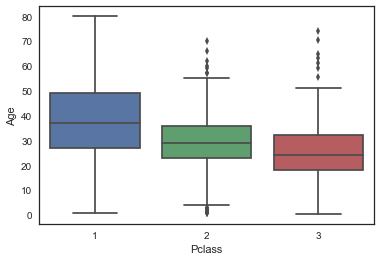

In [26]:
g = sns.boxplot(y ='Age' , x  = 'Pclass', data = train)

C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


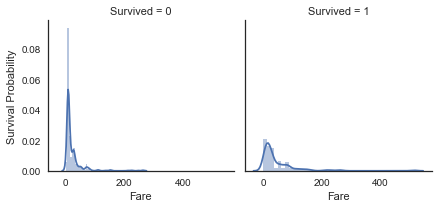

In [27]:
g = sns.FacetGrid(data = train ,col =  'Survived')
g.map(sns.distplot,'Fare')
g.set_ylabels('Survival Probability')

Text(0,0.5,'Survival probabilty')

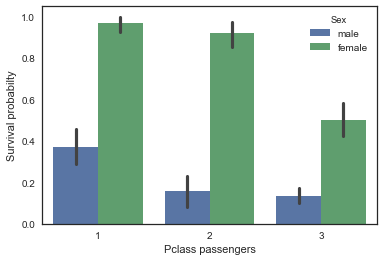

In [28]:
g = sns.barplot(x='Pclass',y='Survived', data = train, hue = 'Sex')
g.set_xlabel('Pclass passengers')
g.set_ylabel('Survival probabilty')

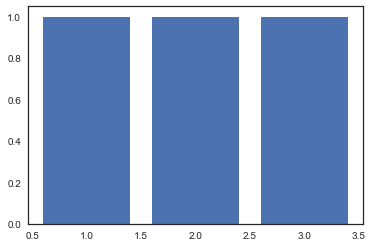

In [29]:
g = plt.bar('Pclass','Survived', data = train)

In [30]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


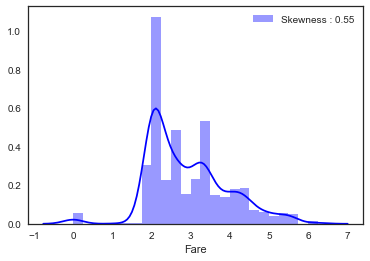

In [31]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

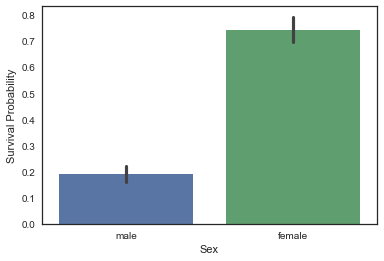

In [32]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

Text(0.5,0,'Sex')

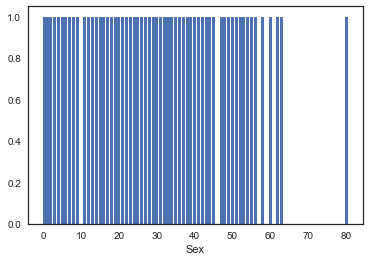

In [33]:
g = plt.bar(train["Age"],train["Survived"])
plt.xlabel('Sex')

In [34]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


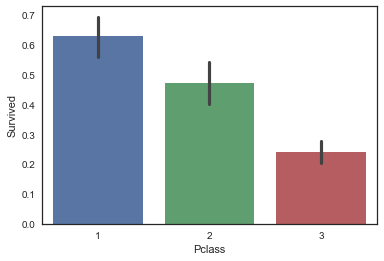

In [35]:
sns.barplot(x='Pclass',y='Survived',data = train)

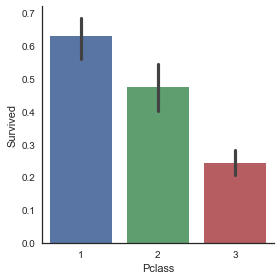

In [36]:
sns.factorplot(x='Pclass',y='Survived',data = train, kind = 'bar')

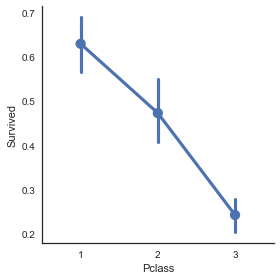

In [37]:
sns.factorplot(x='Pclass',y='Survived',data = train, kind = 'point')

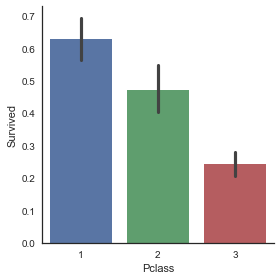

In [38]:
sns.factorplot(x='Pclass',y='Survived',data = train, kind = 'bar')


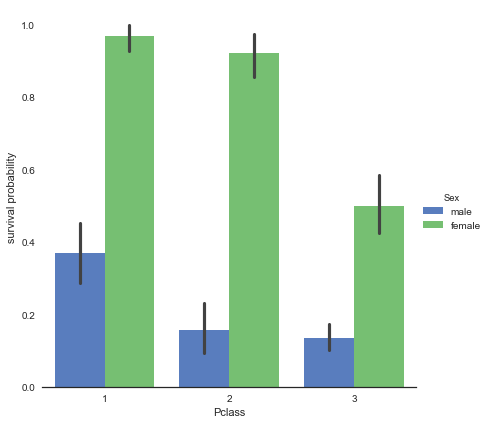

In [39]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Text(0.5,0,'survival probability')

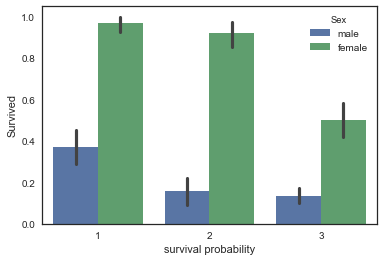

In [40]:
g = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train)
g.set_xlabel("survival probability")

In [41]:
dataset["Embarked"].isnull().sum()

2

In [42]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

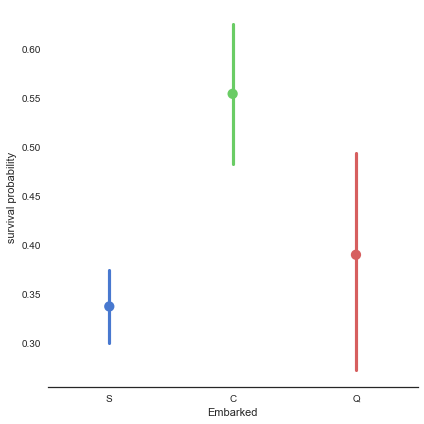

In [43]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="point", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

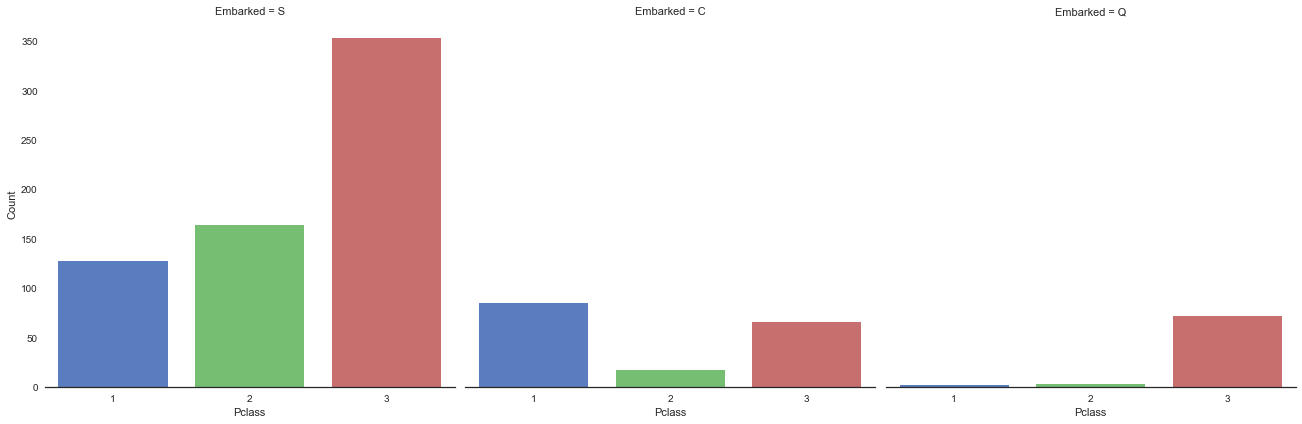

In [44]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

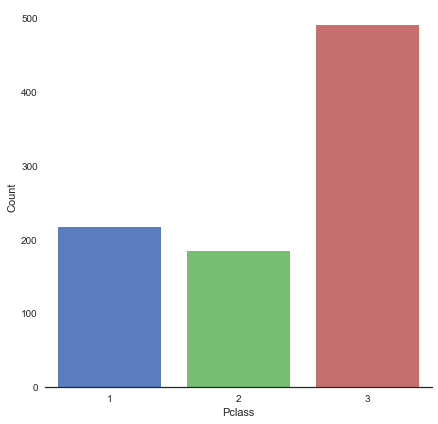

In [45]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

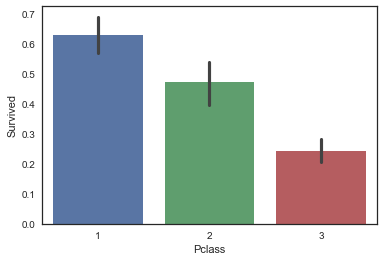

In [46]:
sns.barplot(x='Pclass',y='Survived',data = train)


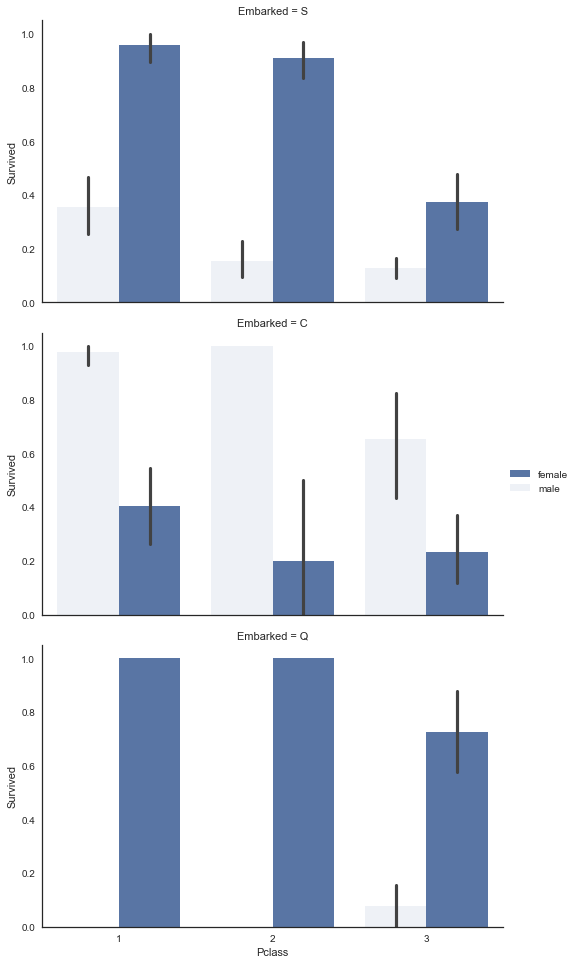

In [47]:
FacetGrid = sns.FacetGrid(train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.barplot , 'Pclass','Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

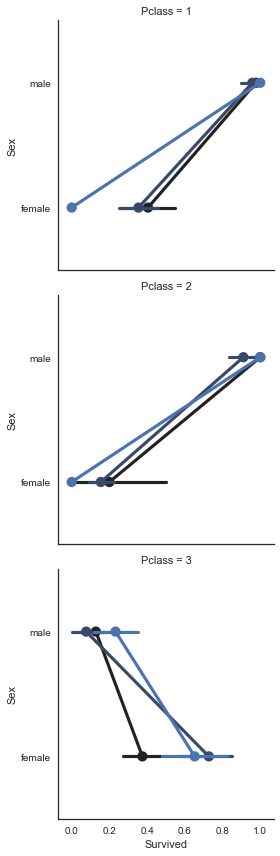

In [48]:
facet = sns.FacetGrid(train, row = 'Pclass',size=4, aspect =1)
facet.map(sns.pointplot, 'Survived', 'Sex','Embarked',palette=None,  order=None, hue_order=None,sharex =False)

C:\py\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


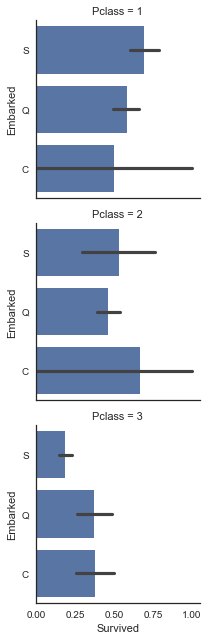

In [49]:
facett = sns.FacetGrid(train, row = 'Pclass')
facett.map(sns.barplot,'Survived','Embarked')

C:\py\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


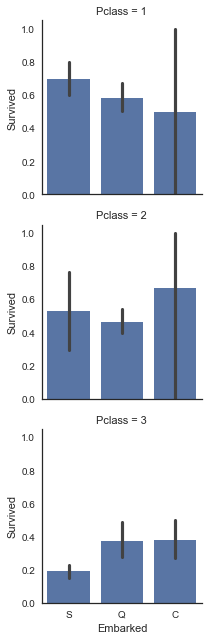

In [50]:
facett = sns.FacetGrid(train, row = 'Pclass')
facett.map(sns.barplot,'Embarked','Survived')

C:\py\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\py\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


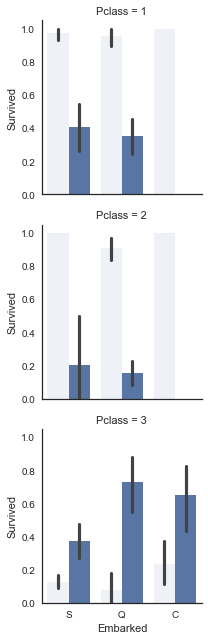

In [51]:
facett = sns.FacetGrid(train, row = 'Pclass')
facett.map(sns.barplot,'Embarked','Survived','Sex')

C:\py\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\py\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


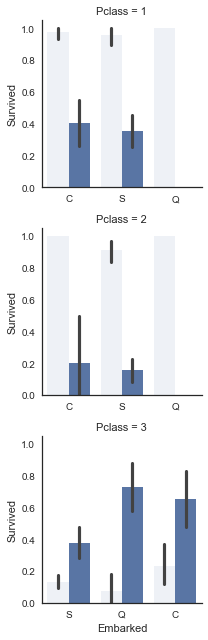

In [52]:
facett = sns.FacetGrid(train, row = 'Pclass',sharex=False)
facett.map(sns.barplot,'Embarked','Survived','Sex')

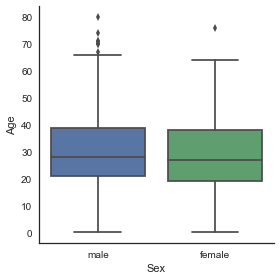

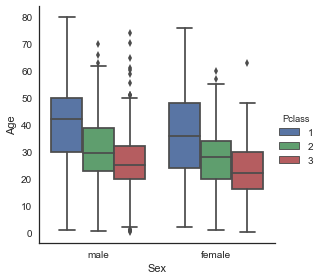

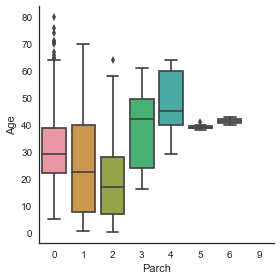

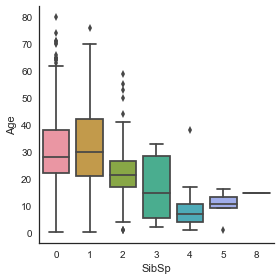

In [53]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

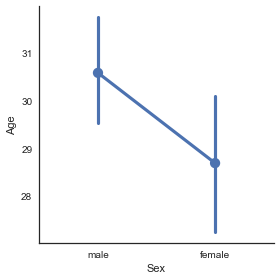

In [54]:
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="point")

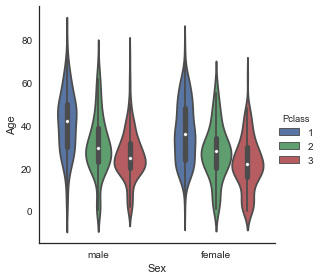

In [55]:
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="violin")

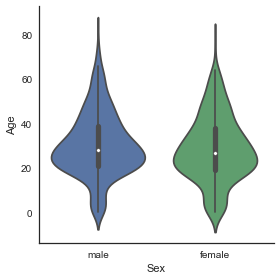

In [56]:
g = sns.factorplot(y="Age",x="Sex", data=dataset,kind="violin")

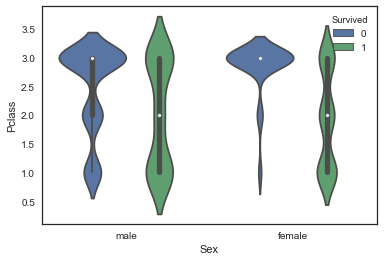

In [57]:
sns.violinplot(y='Pclass',x='Sex',hue = 'Survived', data =train)

C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


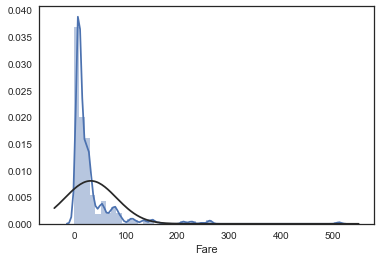

In [58]:
from scipy.stats import norm,skew
sns.distplot(train['Fare'] , fit = norm);

In [60]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

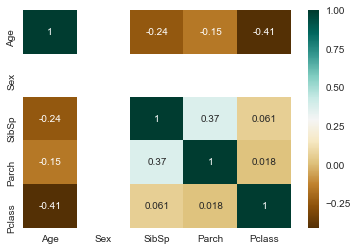

In [61]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

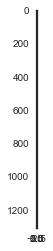

In [63]:
plt.imshow(dataset[["Age","Sex","SibSp","Parch","Pclass"]], cmap='hot', interpolation='nearest')

In [64]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\py\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


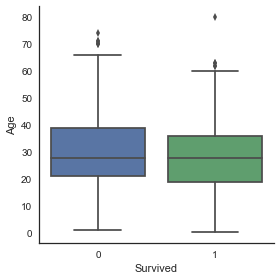

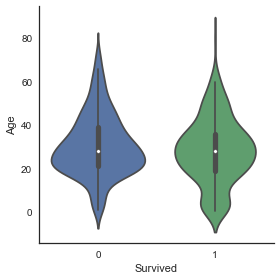

In [67]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

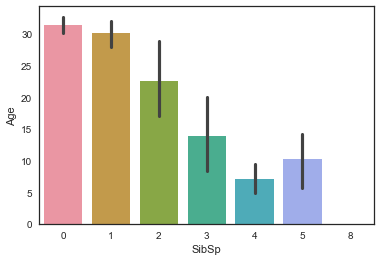

In [66]:
g=sns.barplot(y="Age", x = "SibSp",data = train)

C:\py\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


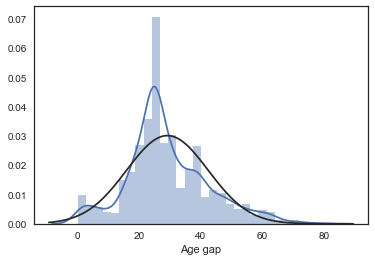

In [68]:
g = sns.distplot(dataset['Age'], fit = norm)
g.set_xlabel('Age gap')
g.legend()

In [69]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [70]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()


0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [71]:
namee = 'Sai,rama.Chaitanya'
namee.split(",")[1].split(".")[0]

'rama'

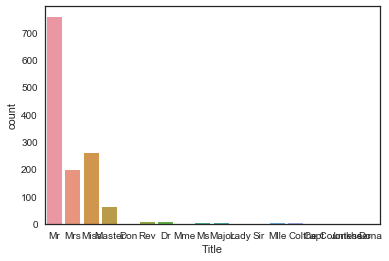

In [72]:
sns.countplot('Title', data= dataset)

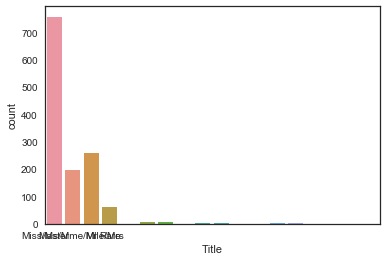

In [73]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

In [74]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

Text(0.5,0,'Master')

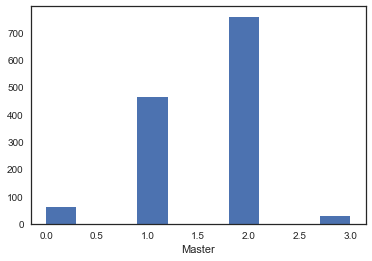

In [75]:
plt.hist(dataset["Title"])
plt.xlabel("Master")

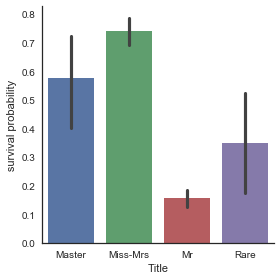

In [76]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

No handles with labels found to put in legend.


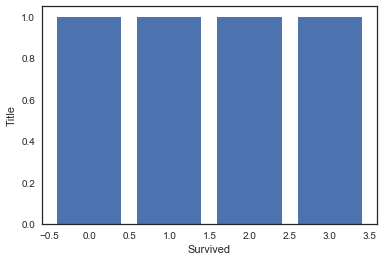

In [77]:
plt.bar(dataset["Title"],dataset["Survived"],data=dataset)
plt.xlabel('Survived')
plt.ylabel('Title')
plt.legend()

In [78]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)


In [79]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

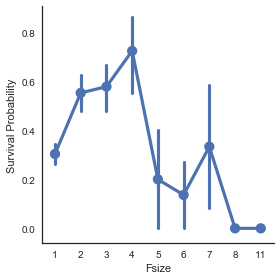

In [80]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

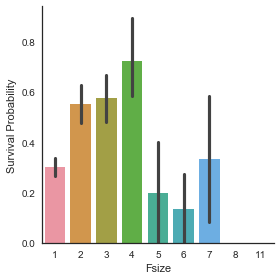

In [81]:
g = sns.factorplot(x="Fsize",y="Survived",kind='bar',data = dataset)
g = g.set_ylabels("Survival Probability")

<BarContainer object of 1309 artists>

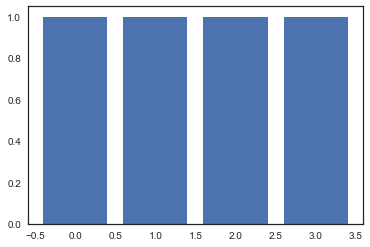

In [82]:
plt.bar(dataset["Title"],dataset["Survived"],data=dataset)

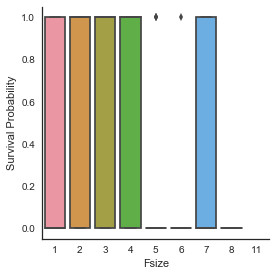

In [313]:
g = sns.factorplot(x="Fsize",y="Survived",kind='box',data = dataset)
g = g.set_ylabels("Survival Probability")

In [85]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

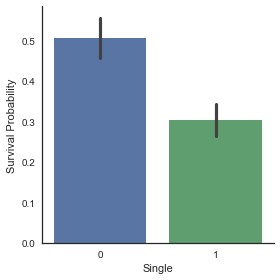

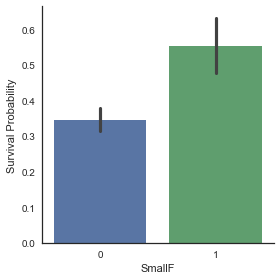

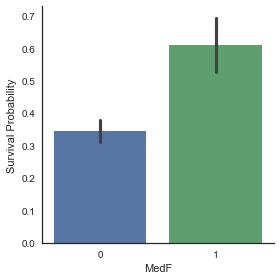

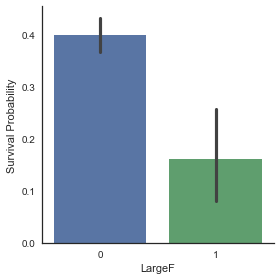

In [86]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

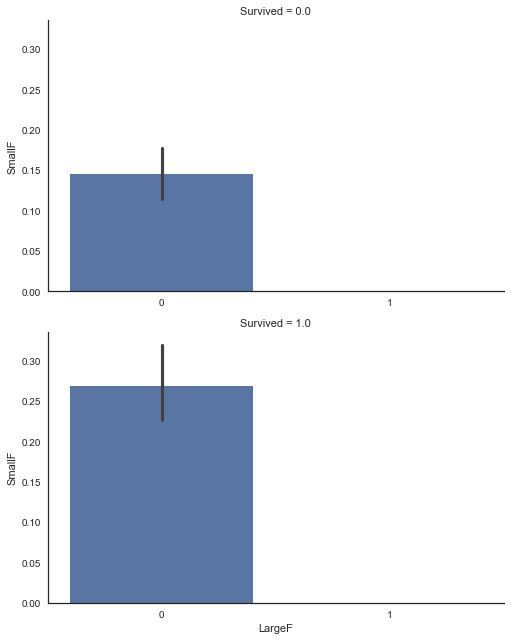

In [87]:
fac= sns.FacetGrid(dataset,row= 'Survived',size=4.5, aspect=1.6,sharex= False)
fac.map(sns.barplot,'LargeF','SmallF',palette=None ,order=None, hue_order=None )




Age              0.000000
Cabin           77.463713
Embarked         0.000000
Fare             0.000000
Parch            0.000000
PassengerId      0.000000
Pclass           0.000000
Sex            100.000000
SibSp            0.000000
Survived        31.932773
Ticket           0.000000
Title            0.000000
Fsize            0.000000
Single           0.000000
SmallF           0.000000
MedF             0.000000
LargeF           0.000000
dtype: float64


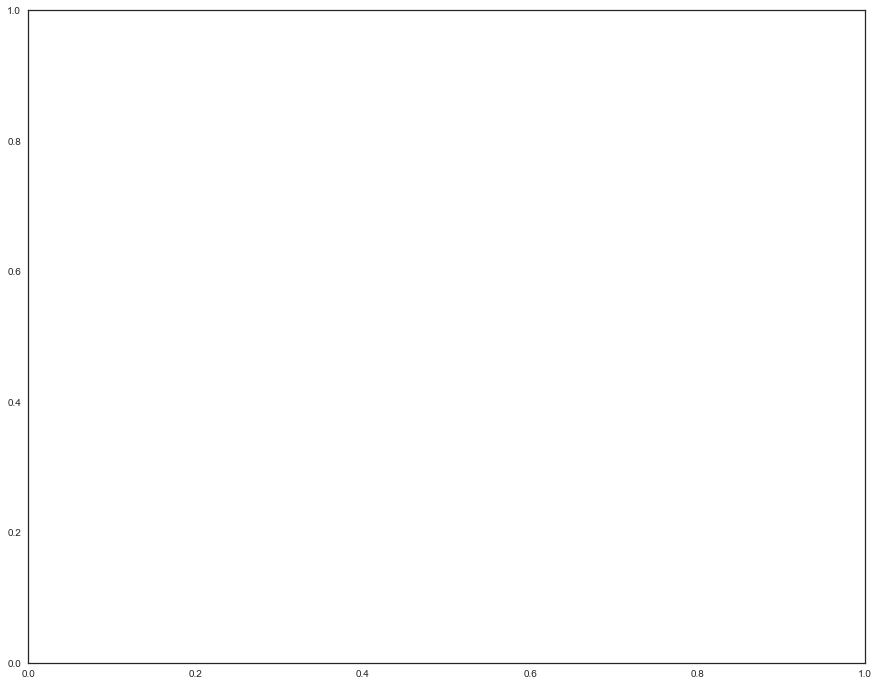

In [88]:
f, ax = plt.subplots(figsize=(15, 12))
missing_values = dataset.isnull().sum()/len(dataset) *100
print(missing_values)

Text(0.5,1,'Percent missing data by feature')

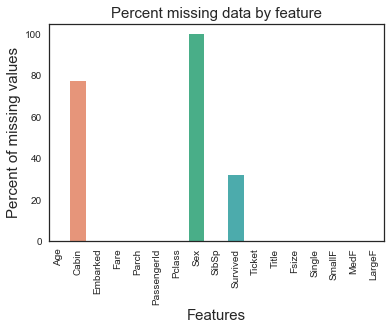

In [89]:
sns.barplot(x=missing_values.index, y=missing_values)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [90]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [91]:
dataset["Cabin"].isnull().sum()

1014

In [92]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [93]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

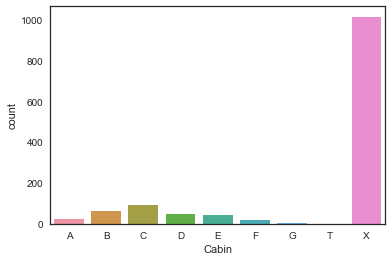

In [94]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

In [95]:
from scipy import stats


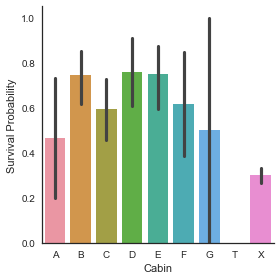

In [96]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [97]:
train.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [101]:
dataset.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

In [102]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

KeyError: "['Cabin'] not in index"

In [103]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [118]:
Ticket =[]
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [119]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [121]:

dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

KeyError: 'Pclass'

In [122]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [123]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\py\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [124]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

C:\py\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [125]:
kfold = StratifiedKFold(n_splits=10)

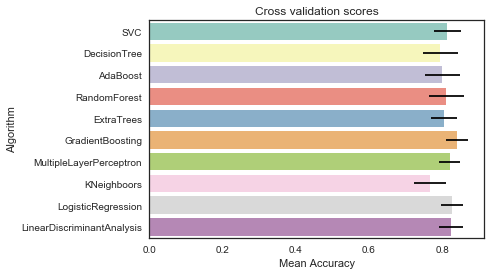

In [138]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [139]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 145 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.3s finished


In [140]:
gsadaDTC.best_score_

0.8172531214528944

In [141]:
print(cv_res)

   CrossValMeans  CrossValerrors                   Algorithm
0       0.813828        0.036804                         SVC
1       0.794625        0.047372                DecisionTree
2       0.800294        0.047899                    AdaBoost
3       0.811632        0.047179                RandomForest
4       0.804788        0.034631                  ExtraTrees
5       0.841075        0.029700            GradientBoosting
6       0.820672        0.028562     MultipleLayerPerceptron
7       0.767314        0.043763                 KNeighboors
8       0.826341        0.029606          LogisticRegression
9       0.824068        0.033392  LinearDiscriminantAnalysis


In [148]:
cv_scores = pd.DataFrame({"CROSSVAL_MEANS" :cv_means,"CrossValerrors": cv_std ,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
print(cv_scores)


   CROSSVAL_MEANS  CrossValerrors                   Algorithm
0        0.813828        0.036804                         SVC
1        0.794625        0.047372                DecisionTree
2        0.800294        0.047899                    AdaBoost
3        0.811632        0.047179                RandomForest
4        0.804788        0.034631                  ExtraTrees
5        0.841075        0.029700            GradientBoosting
6        0.820672        0.028562     MultipleLayerPerceptron
7        0.767314        0.043763                 KNeighboors
8        0.826341        0.029606          LogisticRegression
9        0.824068        0.033392  LinearDiscriminantAnalysis


In [149]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   45.1s finished


0.8308740068104427

In [150]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   38.8s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   47.5s finished


0.8399545970488081

In [151]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 307 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 713 out of 720 | elapsed:   25.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   25.8s finished


0.8354143019296254

In [152]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   28.9s finished


0.8297389330306469

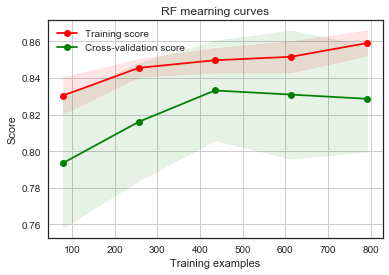

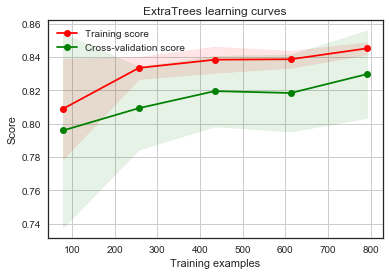

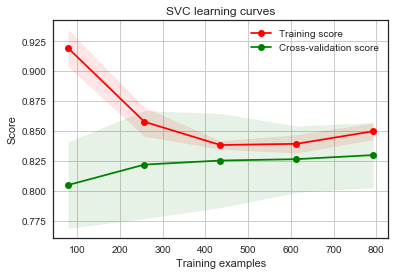

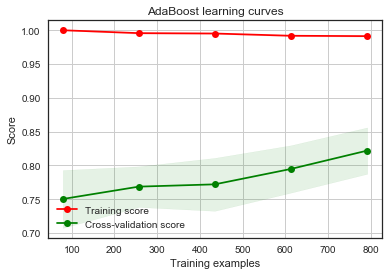

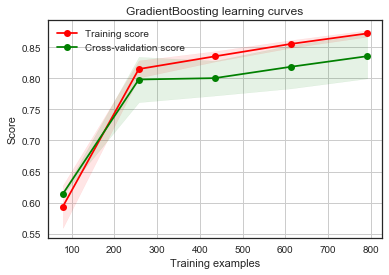

In [153]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

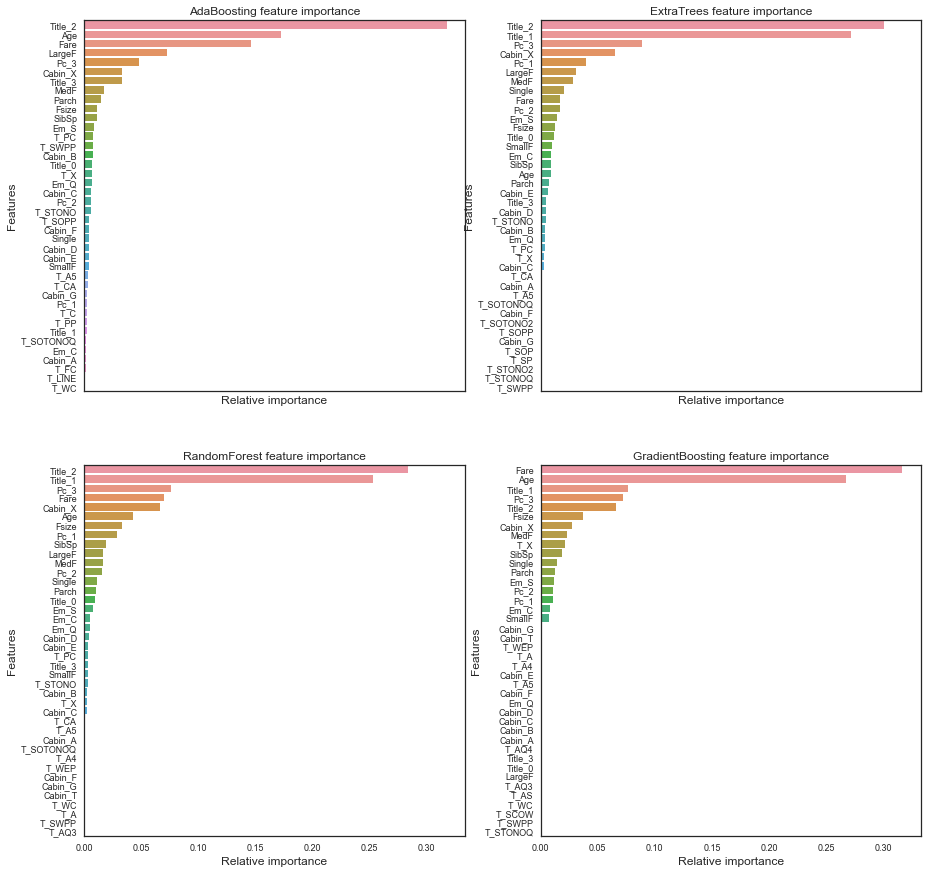

In [154]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [168]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)


In [163]:
train.columns.to_frame()

,0
Age,Age
Fare,Fare
Parch,Parch
Sex,Sex
SibSp,SibSp
Survived,Survived
Fsize,Fsize
Single,Single
SmallF,SmallF
MedF,MedF


In [164]:
corr = train.corr()
corr.style.background_gradient()

C:\py\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [171]:
train.isnull().sum()

Age          0
Fare         0
Parch        0
SibSp        0
Survived     0
Fsize        0
Single       0
SmallF       0
MedF         0
LargeF       0
Title_0      0
Title_1      0
Title_2      0
Title_3      0
Em_C         0
Em_Q         0
Em_S         0
Cabin_A      0
Cabin_B      0
Cabin_C      0
Cabin_D      0
Cabin_E      0
Cabin_F      0
Cabin_G      0
Cabin_T      0
Cabin_X      0
T_A          0
T_A4         0
T_A5         0
T_AQ3        0
            ..
T_FCC        0
T_Fa         0
T_LINE       0
T_LP         0
T_PC         0
T_PP         0
T_PPP        0
T_SC         0
T_SCA3       0
T_SCA4       0
T_SCAH       0
T_SCOW       0
T_SCPARIS    0
T_SCParis    0
T_SOC        0
T_SOP        0
T_SOPP       0
T_SOTONO2    0
T_SOTONOQ    0
T_SP         0
T_STONO      0
T_STONO2     0
T_STONOQ     0
T_SWPP       0
T_WC         0
T_WEP        0
T_X          0
Pc_1         0
Pc_2         0
Pc_3         0
Length: 66, dtype: int64

In [172]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,881.0,29.092701,13.469549,0.42,22.000000,26.000000,37.000000,80.000000
Fare,881.0,2.896427,1.006439,0.00,2.070022,2.670985,3.442819,6.238967
Parch,881.0,0.377980,0.792818,0.00,0.000000,0.000000,0.000000,6.000000
SibSp,881.0,0.527809,1.107602,0.00,0.000000,0.000000,1.000000,8.000000
Survived,881.0,0.385925,0.487090,0.00,0.000000,0.000000,1.000000,1.000000
Fsize,881.0,1.905789,1.612867,1.00,1.000000,1.000000,2.000000,11.000000
Single,881.0,0.600454,0.490083,0.00,0.000000,1.000000,1.000000,1.000000
SmallF,881.0,0.182747,0.386678,0.00,0.000000,0.000000,0.000000,1.000000
MedF,881.0,0.147560,0.354864,0.00,0.000000,0.000000,0.000000,1.000000
LargeF,881.0,0.069240,0.254005,0.00,0.000000,0.000000,0.000000,1.000000


In [173]:
train1 = train.copy()

In [175]:
train1.isnull().sum()

Age          0
Fare         0
Parch        0
SibSp        0
Survived     0
Fsize        0
Single       0
SmallF       0
MedF         0
LargeF       0
Title_0      0
Title_1      0
Title_2      0
Title_3      0
Em_C         0
Em_Q         0
Em_S         0
Cabin_A      0
Cabin_B      0
Cabin_C      0
Cabin_D      0
Cabin_E      0
Cabin_F      0
Cabin_G      0
Cabin_T      0
Cabin_X      0
T_A          0
T_A4         0
T_A5         0
T_AQ3        0
            ..
T_FCC        0
T_Fa         0
T_LINE       0
T_LP         0
T_PC         0
T_PP         0
T_PPP        0
T_SC         0
T_SCA3       0
T_SCA4       0
T_SCAH       0
T_SCOW       0
T_SCPARIS    0
T_SCParis    0
T_SOC        0
T_SOP        0
T_SOPP       0
T_SOTONO2    0
T_SOTONOQ    0
T_SP         0
T_STONO      0
T_STONO2     0
T_STONOQ     0
T_SWPP       0
T_WC         0
T_WEP        0
T_X          0
Pc_1         0
Pc_2         0
Pc_3         0
Length: 66, dtype: int64

In [178]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca2_results = pca2.fit_transform(train1)

TypeError: You must first set_array for mappable

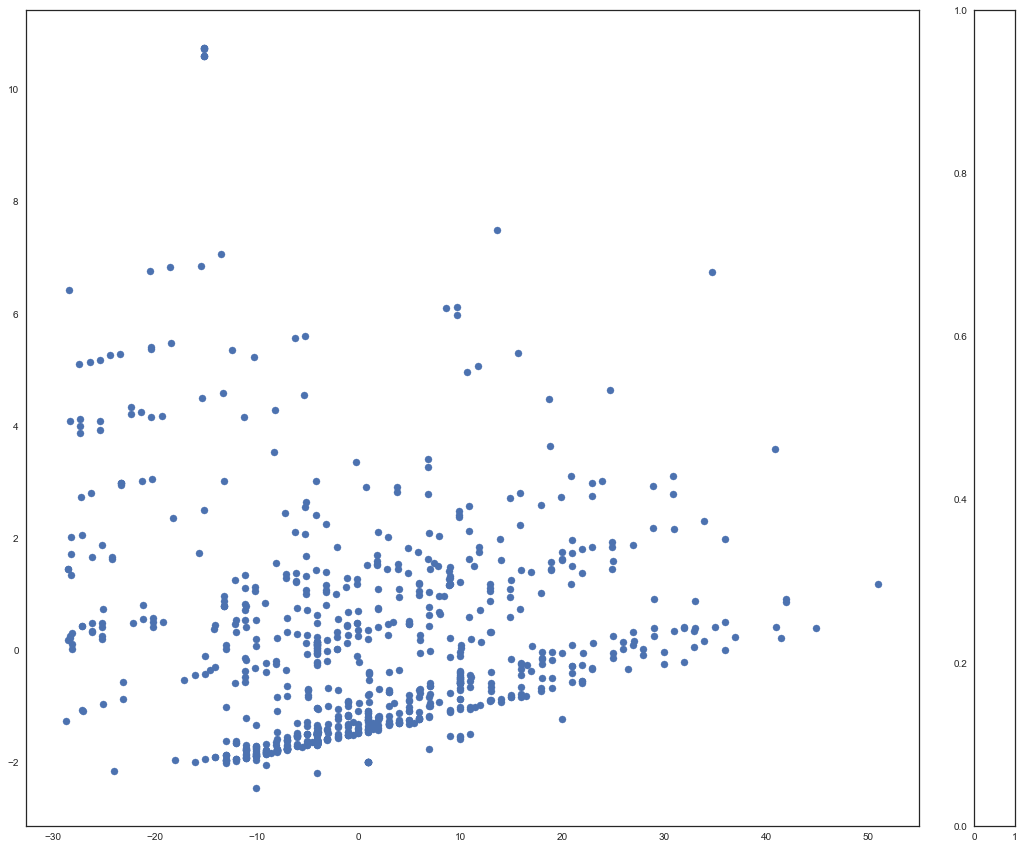

In [181]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(20,15))
points = ax.scatter(pca2_results[:,0], pca2_results[:,1], s=50, cmap=cmap)
f.colorbar(points)
plt.show()

In [182]:
from sklearn.manifold import TSNE
tsne2 = TSNE(n_components=2)
tsne2_results = tsne2.fit_transform(train1)

TypeError: You must first set_array for mappable

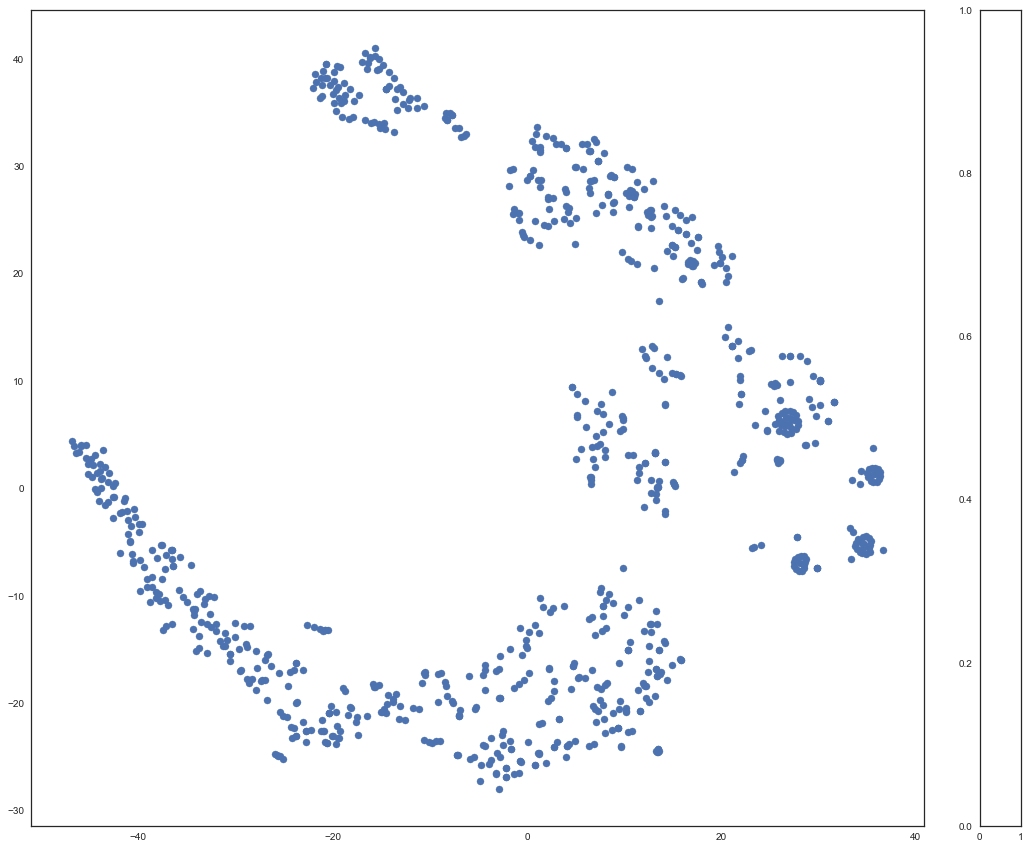

In [183]:
f, ax = plt.subplots(figsize=(20,15))
points = ax.scatter(tsne2_results[:,0], tsne2_results[:,1], s=50, cmap=cmap)
f.colorbar(points)
plt.show()

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numpy.random import seed
from numpy.random import randn
import seaborn as sns
from PyAstronomy import pyasl

In [185]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import ExtraTreesClassifier

sns.set_style('whitegrid')

%matplotlib inline

In [187]:
computed_mean = np.mean(train['Age'])
print(f"The computed mean is {computed_mean}")

interval = stats.t.interval(0.95, len(train['Age'])-1, loc=np.mean(train['Age']), scale=stats.sem(train['Age']))
print(f"The mean has a confidence limit of {interval}")

The computed mean is 29.092701475595913
The mean has a confidence limit of (28.202043596706545, 29.98335935448528)


In [194]:
true_mu = 1
# Checking for data1
onesample_results = stats.ttest_1samp(train['Fare'], true_mu)

onesample_results



Ttest_1sampResult(statistic=55.9289161072605, pvalue=5.825958906871474e-292)

In [195]:

twosample_results = stats.ttest_ind(train['Fare'], train['Age'])
twosample_results


Ttest_indResult(statistic=-57.56592439072869, pvalue=0.0)

In [196]:
stats.f_oneway(train['Fare'], train['Age'])

F_onewayResult(statistic=3313.8356509590935, pvalue=0.0)

In [197]:
stats.bartlett(train['Fare'], train['Age'])

BartlettResult(statistic=3353.4170094140613, pvalue=0.0)

In [200]:
stats.levene(train['Fare'], train['Age'])

LeveneResult(statistic=838.5229763430516, pvalue=4.130340049812456e-151)

In [201]:
print( 'Excess kurtosis of normal distribution (should be 0): {}'.format( stats.kurtosis(train['Age']) ))
print( 'Skewness of normal distribution (should be 0): {}'.format( stats.skew(train['Age']) ))

Excess kurtosis of normal distribution (should be 0): 0.6196659465501551
Skewness of normal distribution (should be 0): 0.49293481662384026


In [202]:
from scipy.stats import boxcox

In [204]:
data = boxcox(train['Age'], 0)

In [206]:
print( 'Excess kurtosis of normal distribution (should be 0): {}'.format( stats.kurtosis(data) ))
print( 'Skewness of normal distribution (should be 0): {}'.format( stats.skew(data) ))

Excess kurtosis of normal distribution (should be 0): 8.099846962175155
Skewness of normal distribution (should be 0): -2.467949771573599


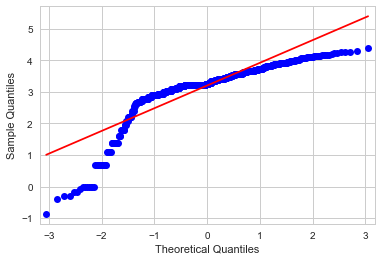

In [207]:
from statsmodels.graphics.gofplots import qqplot
qqplot(data, line='s');

In [208]:
stat, p = stats.shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.765, p=0.000


In [209]:
stat, p = stats.normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=481.858, p=0.000


In [227]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [228]:
def calculate_vif_(X):

    '''X - pandas dataframe'''
    thresh = 5.0
    variables = range(X.shape[1])

    for i in np.arange(0, len(variables)):
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
        print(vif)
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]

    print('Remaining variables:')
    print(X.columns[variables])
    return X

In [241]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)

accuracy_score(y_true, y_pred, normalize=True)
accuracy_score(y_true, y_pred, normalize=False)

2

In [242]:
import numpy as np
from sklearn.metrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_scores)  


0.8333333333333333

In [244]:

from sklearn.metrics import brier_score_loss
y_true = np.array([0, 1, 1, 0])
y_true_categorical = np.array(["spam", "ham", "ham", "spam"])
y_prob = np.array([0.1, 0.9, 0.8, 0.3])
brier_score_loss(y_true, y_prob)  
brier_score_loss(y_true, 1-y_prob, pos_label=0)  
brier_score_loss(y_true_categorical, y_prob,                          pos_label="ham")  
brier_score_loss(y_true, np.array(y_prob) > 0.5)


0.0

In [246]:
from sklearn.metrics import f1_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
f1_score(y_true, y_pred, average='macro')  
f1_score(y_true, y_pred, average='micro')  
f1_score(y_true, y_pred, average='weighted')  
f1_score(y_true, y_pred, average=None)

array([0.8, 0. , 0. ])

In [247]:
from sklearn.metrics import roc_auc_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
roc_auc_score(y_true, y_scores)

0.75

In [248]:
from sklearn.metrics import precision_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
precision_score(y_true, y_pred, average='macro')  
precision_score(y_true, y_pred, average='micro')  
precision_score(y_true, y_pred, average='weighted')

precision_score(y_true, y_pred, average=None)  


array([0.66666667, 0.        , 0.        ])

In [250]:
from sklearn.metrics import explained_variance_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
explained_variance_score(y_true, y_pred)  
print(explained_variance_score)
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
explained_variance_score(y_true, y_pred, multioutput='uniform_average')
print(explained_variance_score)

<function explained_variance_score at 0x0000000009E568C8>
<function explained_variance_score at 0x0000000009E568C8>


In [251]:
from sklearn.metrics import mean_squared_log_error
y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
mean_squared_log_error(y_true, y_pred)  

y_true = [[0.5, 1], [1, 2], [7, 6]]
y_pred = [[0.5, 2], [1, 2.5], [8, 8]]
mean_squared_log_error(y_true, y_pred)  

mean_squared_log_error(y_true, y_pred, multioutput='raw_values')

mean_squared_log_error(y_true, y_pred, multioutput=[0.3, 0.7])


0.060029394179700345

In [252]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
r2_score(y_true, y_pred)

0.9486081370449679

In [253]:
from sklearn.metrics import cohen_kappa_score
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cohen_kappa_score(y_true, y_pred)


0.4285714285714286

In [254]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)


array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

In [255]:
#The classification_report function builds a text report showing the main classification metrics.
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.67      1.00      0.80         2
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.50      0.67         2

avg / total       0.67      0.60      0.59         5



In [256]:
#The hamming_loss computes the average Hamming loss or Hamming distance between two sets of samples
from sklearn.metrics import hamming_loss
y_pred = [1, 2, 3, 4]
y_true = [2, 2, 3, 4]
hamming_loss(y_true, y_pred)


0.25

In [257]:
import numpy as np
from sklearn.metrics import jaccard_similarity_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
jaccard_similarity_score(y_true, y_pred)

jaccard_similarity_score(y_true, y_pred, normalize=False)

2

In [259]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
scoring = {'accuracy': make_scorer(accuracy_score),
         'prec': 'precision'}

In [262]:

from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(
y_true, y_scores)


In [264]:
from sklearn.metrics import roc_curve
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=2)


In [265]:
from sklearn.metrics import zero_one_loss
y_pred = [1, 2, 3, 4]
y_true = [2, 2, 3, 4]
zero_one_loss(y_true, y_pred)


0.25

In [266]:
from sklearn.metrics import mean_squared_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_squared_error(y_true, y_pred)


0.375

In [267]:
from sklearn.metrics import mean_squared_log_error
y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
mean_squared_log_error(y_true, y_pred)  


0.03973012298459379

In [268]:
from sklearn.metrics import median_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
median_absolute_error(y_true, y_pred)


0.5

In [271]:
def tied_rank(x):
    """
    Computes the tied rank of elements in x.
    This function computes the tied rank of elements in x.
    Parameters
    ----------
    x : list of numbers, numpy array
    Returns
    -------
    score : list of numbers
            The tied rank f each element in x
    """
    sorted_x = sorted(zip(x,range(len(x))))
    r = [0 for k in x]
    cur_val = sorted_x[0][0]
    last_rank = 0
    for i in range(len(sorted_x)):
        if cur_val != sorted_x[i][0]:
            cur_val = sorted_x[i][0]
            for j in range(last_rank, i): 
                r[sorted_x[j][1]] = float(last_rank+1+i)/2.0
            last_rank = i
        if i==len(sorted_x)-1:
            for j in range(last_rank, i+1): 
                r[sorted_x[j][1]] = float(last_rank+i+2)/2.0
    return r


In [269]:
def auc(actual, posterior):
    """
    Computes the area under the receiver-operater characteristic (AUC)
    This function computes the AUC error metric for binary classification.
    Parameters
    ----------
    actual : list of binary numbers, numpy array
             The ground truth value
    posterior : same type as actual
                Defines a ranking on the binary numbers, from most likely to
                be positive to least likely to be positive.
    Returns
    -------
    score : double
            The mean squared error between actual and posterior
    """
    r = tied_rank(posterior)
    num_positive = len([0 for x in actual if x==1])
    num_negative = len(actual)-num_positive
    sum_positive = sum([r[i] for i in range(len(r)) if actual[i]==1])
    auc = ((sum_positive - num_positive*(num_positive+1)/2.0) /
           (num_negative*num_positive))
    return auc

In [276]:
def ae(actual, predicted):
    """
    Computes the absolute error.
    This function computes the absolute error between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The absolute error between actual and predicted
    """
    return np.abs(np.array(actual)-np.array(predicted))

def ce(actual, predicted):
    """
    Computes the classification error.
    This function computes the classification error between two lists
    Parameters
    ----------
    actual : list
             A list of the true classes
    predicted : list
                A list of the predicted classes
    Returns
    -------
    score : double
            The classification error between actual and predicted
    """
    return (sum([1.0 for x,y in zip(actual,predicted) if x != y]) /
            len(actual))

def mae(actual, predicted):
    """
    Computes the mean absolute error.
    This function computes the mean absolute error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The mean absolute error between actual and predicted
    """
    return np.mean(ae(actual, predicted))

def mse(actual, predicted):
    """
    Computes the mean squared error.
    This function computes the mean squared error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The mean squared error between actual and predicted
    """
    return np.mean(se(actual, predicted))

def msle(actual, predicted):
    """
    Computes the mean squared log error.
    This function computes the mean squared log error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The mean squared log error between actual and predicted
    """
    return np.mean(sle(actual, predicted))

def rmse(actual, predicted):
    """
    Computes the root mean squared error.
    This function computes the root mean squared error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The root mean squared error between actual and predicted
    """
    return np.sqrt(mse(actual, predicted))

def rmsle(actual, predicted):
    """
    Computes the root mean squared log error.
    This function computes the root mean squared log error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The root mean squared log error between actual and predicted
    """
    return np.sqrt(msle(actual, predicted))

def se(actual, predicted):
    """
    Computes the squared error.
    This function computes the squared error between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The squared error between actual and predicted
    """
    return np.power(np.array(actual)-np.array(predicted), 2)

def sle(actual, predicted):
    """
    Computes the squared log error.
    This function computes the squared log error between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The squared log error between actual and predicted
    """
    return (np.power(np.log(np.array(actual)+1) - 
            np.log(np.array(predicted)+1), 2))

def ll(actual, predicted):
    """
    Computes the log likelihood.
    This function computes the log likelihood between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The log likelihood error between actual and predicted
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    err = np.seterr(all='ignore')
    score = -(actual*np.log(predicted)+(1-actual)*np.log(1-predicted))
    np.seterr(divide=err['divide'], over=err['over'],
              under=err['under'], invalid=err['invalid'])
    if type(score)==np.ndarray:
        score[np.isnan(score)] = 0
    else:
        if np.isnan(score):
            score = 0
    return score

def log_loss(actual, predicted):
    """
    Computes the log loss.
    This function computes the log loss between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The log loss between actual and predicted
    """
    return np.mean(ll(actual, predicted))

In [281]:
rmse(y_true, y_pred)
log_loss(y_true, y_pred)
ll(y_true,y_pred)

array([  0., -inf,   0.,   0.])

In [282]:
import numpy as np


def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def linear_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = abs(i - j) / float(num_ratings - 1)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            if i == j:
                d = 0.0
            else:
                d = 1.0
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def weighted_mean_quadratic_weighted_kappa(solution, submission):
    predicted_score = submission[submission.columns[-1]].copy()
    predicted_score.name = "predicted_score"
    if predicted_score.index[0] == 0:
        predicted_score = predicted_score[:len(solution)]
        predicted_score.index = solution.index
    combined = solution.join(predicted_score, how="left")
    groups = combined.groupby(by="essay_set")
    kappas = [quadratic_weighted_kappa(group[1]["essay_score"], group[1]["predicted_score"]) for group in groups]
    weights = [group[1]["essay_weight"].irow(0) for group in groups]
    return mean_quadratic_weighted_kappa(kappas, weights=weights)